# Applying Basic Reinforcement Learning to Blackjack
The aim of this project is to produce a Blackjack strategy using decaying epsilon-greedy Q-learning and benchmark it against a Random Agent, a Normal Player and the Hit 17 Strategy.

## The Environment
We use the Open AI Blackjack environment, which can be found [here](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py).

In [1]:
import gym
import matplotlib.pyplot as plt

env = gym.make('Blackjack-v0')
env.reset()

(12, 8, False)

## Random Agent
We calculate the average payout/1,000 rounds of the Random Agent, which takes random actions each round.

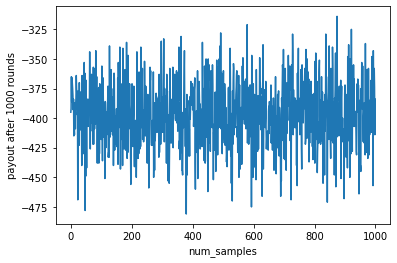

Average payout after 1000 rounds is -396.967


In [2]:
num_rounds = 1000 # payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples

average_payouts = []

for sample in range(num_samples):
    round = 1
    total_payout = 0 # to store total payout over num_rounds
    
    while round <= num_rounds:
        action = env.action_space.sample() # take random action 
        obs, payout, is_done, _ = env.step(action) # this is from gym (payout)
        total_payout += payout
        if is_done:
            env.reset() # environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

rand_av_payouts = sum(average_payouts)/num_samples

fig = plt.figure()
plt.plot(average_payouts)                
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show() 
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))

## Normal Player
We use the strategy outlined in the Kendall and Smith (2003) paper (specifically Figure 11, see [here](https://pdfs.semanticscholar.org/e1dd/06616e2d18179da7a3643cb3faab95222c8b.pdf)) to represent the "normal player" strategy, which is simulated to find out the average payout/1,000 rounds.

In [4]:
def normal_strategy(player_sum, dealer_up_card):
    """
    Returns appropriate action from a 2D array storing actions
    Each row corresponds to player sum- from 2 to 21
    Each column corresponds to dealer_up_card- from 1 to 10
    """
    actions = [[1]*10]*8 # 2 to 9
    actions.append([1]*4 + [0]*2 + [1]*4) #10
    actions.append([1] + [0]*6 + [1]*3) #11
    actions.append([0] + [1]*9) #12
    actions.append([0]*2 + [1]*8) #13
    actions.append([0]*1 + [1]*9) #14
    actions.append([0]*2 + [1]*8) #15
    actions.append([0]*5 + [1]*5) #16
    actions.append([0]*4 + [1]*6) #17
    actions.extend([[0]*10]*4) # 18 to 21
    
    # dealer_up_card-2 takes care of input 1 which correctly looks up last column
    return actions[player_sum-2][dealer_up_card-2]

# make sure actions have been stored correctly mainly when dealer's upcard is A
assert (normal_strategy(15, 2)) == 0
assert (normal_strategy(15, 1)) == 1


num_rounds = 1000 # payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples
total_payout = 0 # to store total payout over 'num_rounds'

for _ in range(num_samples):
    round = 1
    while round <= num_rounds:
        player_sum, dealer_up_card, is_done = (env._get_obs())
        
        # take action based on normal strategy stored above
        action = normal_strategy(player_sum, dealer_up_card) 
        
        obs, payout, is_done, _ = env.step(action)
        total_payout += payout
        if is_done:
            env.reset() # environment deals new cards to player and dealer
            round += 1

print ("Average payout after {} rounds is {}".format(num_rounds, total_payout/num_samples))
norm_av_payout = total_payout/num_samples

Average payout after 1000 rounds is -101.036


## Payout when using Hit 17 strategy
This is the strategy that casino house dealers employ globally, where they Stick with any hand of 17 or above and Hit otherwise.

In [5]:
def hit17_strategy(player_sum, dealer_up_card):
    """
    Returns appropriate action from a 2D array storing actions
    Each row corresponds to player sum- from 2 to 21
    Each column corresponds to dealer_up_card- from 1 to 10
    """
    actions = [[1]*10]*8 # 2 to 9
    actions.append([1]*10) #10
    actions.append([1]*10) #11
    actions.append([1]*10) #12
    actions.append([1]*10) #13
    actions.append([1]*10) #14
    actions.append([1]*10) #15
    actions.append([1]*10) #16
    actions.append([0]*10) #17
    actions.extend([[0]*10]*4) # 18 to 21
    
    # dealer_up_card-2 takes care of input 1 which correctly looks up last column
    return actions[player_sum-2][dealer_up_card-2]

# make sure actions have been stored correctly mainly when dealer's upcard is A
assert (hit17_strategy(15, 2)) == 1
assert (hit17_strategy(15, 1)) == 1

num_rounds = 1000 # payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples
total_payout = 0 # to store total payout over 'num_rounds'

for _ in range(num_samples):
    round = 1
    while round <= num_rounds:
        player_sum, dealer_up_card, is_done = (env._get_obs())
        
        # take action based on normal strategy stored above
        action = hit17_strategy(player_sum, dealer_up_card) 
        
        obs, payout, is_done, _ = env.step(action)
        total_payout += payout
        if is_done:
            env.reset() # environment deals new cards to player and dealer
            round += 1

print ("Average payout after {} rounds is {}".format(num_rounds, total_payout/num_samples))
hit17_av_payout = total_payout/num_samples

Average payout after 1000 rounds is -78.438


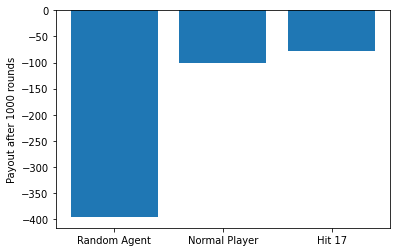

Random Agent: -396.967, Normal Player: -101.036, Hit 17: -78.438


In [6]:
fig = plt.figure()
plt.bar(['Random Agent', 'Normal Player', 'Hit 17'],[rand_av_payouts,norm_av_payout, hit17_av_payout])
plt.ylabel("Payout after 1000 rounds")
plt.show()
#fig.savefig("random_v_normal_v_hit17.png")
print("Random Agent: {}, Normal Player: {}, Hit 17: {}".format(rand_av_payouts,norm_av_payout, hit17_av_payout))

**Comment:**
It is clear to see that Hit 17 is the best strategy as it achieves the highest average payout/1,000 rounds.

## Q-Learning Agent

Below is the implementation of the Q-learning agent.

In [7]:
import random

class Agent():
    def __init__(self, env, epsilon=1.0, alpha=0.5, gamma=0.9, num_episodes_to_train=30000):
        self.env = env

        # looks like n is number of valid actions from the souce code
        self.valid_actions = list(range(self.env.action_space.n))

        # set parameters of the learning agent
        self.Q = dict()          # Q-table which will be a dictionary of tuples
        self.epsilon = epsilon   # random exploration factor
        self.alpha = alpha       # learning factor
        self.gamma = gamma       # discount factor- closer to 1 learns well into distant future

        # epsilon will reduce linearly until it reaches 0 based on num_episodes_to_train
        # epsilon drops to 90% of its inital value in the first 30% of num_episodes_to_train
        # epsilon then drops to 10% of its initial value in the next 40% of num_episodes_to_train
        # epsilon finally becomes 0 in the final 30% of num_episodes_to_train
        self.num_episodes_to_train = num_episodes_to_train # epsilon changes each episode based on this
        self.small_decrement = (0.1 * epsilon) / (0.3 * num_episodes_to_train) # reduces epsilon slowly
        self.big_decrement = (0.8 * epsilon) / (0.4 * num_episodes_to_train) # reduces epilon faster

        self.num_episodes_to_train_left = num_episodes_to_train

    def update_parameters(self):
        """
        - Update epsilon and alpha after each action
        - Set them to 0 if not learning
        """
        if self.num_episodes_to_train_left > 0.7 * self.num_episodes_to_train:
            self.epsilon -= self.small_decrement
        elif self.num_episodes_to_train_left > 0.3 * self.num_episodes_to_train:
            self.epsilon -= self.big_decrement
        elif self.num_episodes_to_train_left > 0:
            self.epsilon -= self.small_decrement
        else:
            self.epsilon = 0.0
            self.alpha = 0.0

        self.num_episodes_to_train_left -= 1

    def create_Q_if_new_observation(self, observation):
        """
        Set intial Q values to 0.0 if observation not already in Q table
        """
        if observation not in self.Q:
            self.Q[observation] = dict((action, 0.0) for action in self.valid_actions)

    def get_maxQ(self, observation):
        """
        Called when the agent is asked to find the maximum Q-value of all actions based on the 'observation' the environment is in.
        """
        self.create_Q_if_new_observation(observation)
        return max(self.Q[observation].values())

    def choose_action(self, observation):
        """
        - Choose which action to take, based on the observation.
        - If observation is seen for the first time, initialise its Q values to 0.0
        """
        self.create_Q_if_new_observation(observation)

        # uniformly distributed random number > epsilon happens with probability 1-epsilon
        if random.random() > self.epsilon: # seb to check this with olecture notes
            maxQ = self.get_maxQ(observation)

            # multiple actions could have maxQ- pick one at random in that case
            # this is also the case when the Q value for this observation were just set to 0.0
            action = random.choice([k for k in self.Q[observation].keys()
                                    if self.Q[observation][k] == maxQ])
        else:
            action = random.choice(self.valid_actions)

        self.update_parameters()

        return action


    def learn(self, observation, action, reward, next_observation):
        """
        - Called after the agent completes an action and receives an award
        - This function does not consider future rewards when conducting learning.
        """

        # Q = Q*(1-alpha) + alpha(reward + discount * utility of next observation)
        # Q = Q - Q * alpha + alpha(reward + discount * self.get_maxQ(next_observation))
        # Q = Q - alpha (-Q + reward + discount * self.get_maxQ(next_observation))
        self.Q[observation][action] += self.alpha * (reward
                                                     + (self.gamma * self.get_maxQ(next_observation))
                                                     - self.Q[observation][action])

### Rate of decrease of exploration factor (epsilon)
`epsilon` is plotted during the training process to illustrate the rate of its decrease.

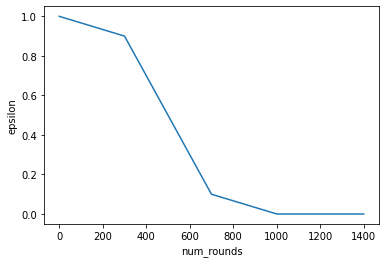

In [8]:
env = gym.make('Blackjack-v0')

total_payout = 0 # to store total payout over num_rounds
average_payouts = []
agent = Agent(env=env, epsilon=1.0, alpha=0.8, gamma=0.9, num_episodes_to_train=1000)

num_rounds = 1000 # payout calculated over num_rounds
num_samples = 1 # num_rounds simulated over num_samples


observation = env.reset()
for sample in range(num_samples):
    round = 1
    epsilon_values = []
    # take action based on Q-table of the agent and learn based on that until num_episodes_to_train = 0
    while round <= num_rounds:
        epsilon_values.append(agent.epsilon)
        action = agent.choose_action(observation)
        next_observation, payout, is_done, _ = env.step(action)
        agent.learn(observation, action, payout, next_observation)
        total_payout += payout
        observation = next_observation
        if is_done:
            observation = env.reset() # environment deals new cards to player and dealer
            round += 1
            average_payouts.append(total_payout/(sample*num_rounds + round))

# plot epsilon over rounds to show rate of its decrease
fig = plt.figure()
plt.xlabel("num_rounds")
plt.ylabel("epsilon")
plt.plot(epsilon_values)
plt.show()
fig.savefig("epsilon_decay.png")
#print ("Average payout after {} rounds is {}".format(num_rounds, total_payout/(num_samples)))

## Running algorithm by training over different number of episodes

Below is the search for the best value of `num_episodes_to_train`.

Average payout after 1000 rounds after training for 1000 episodes is -193.7
Average payout after 1000 rounds after training for 2000 episodes is -242.46
Average payout after 1000 rounds after training for 3000 episodes is -165.44
Average payout after 1000 rounds after training for 4000 episodes is -163.56
Average payout after 1000 rounds after training for 5000 episodes is -180.92
Average payout after 1000 rounds after training for 6000 episodes is -199.18
Average payout after 1000 rounds after training for 7000 episodes is -234.16
Average payout after 1000 rounds after training for 8000 episodes is -191.38
Average payout after 1000 rounds after training for 9000 episodes is -203.9
Average payout after 1000 rounds after training for 10000 episodes is -242.12


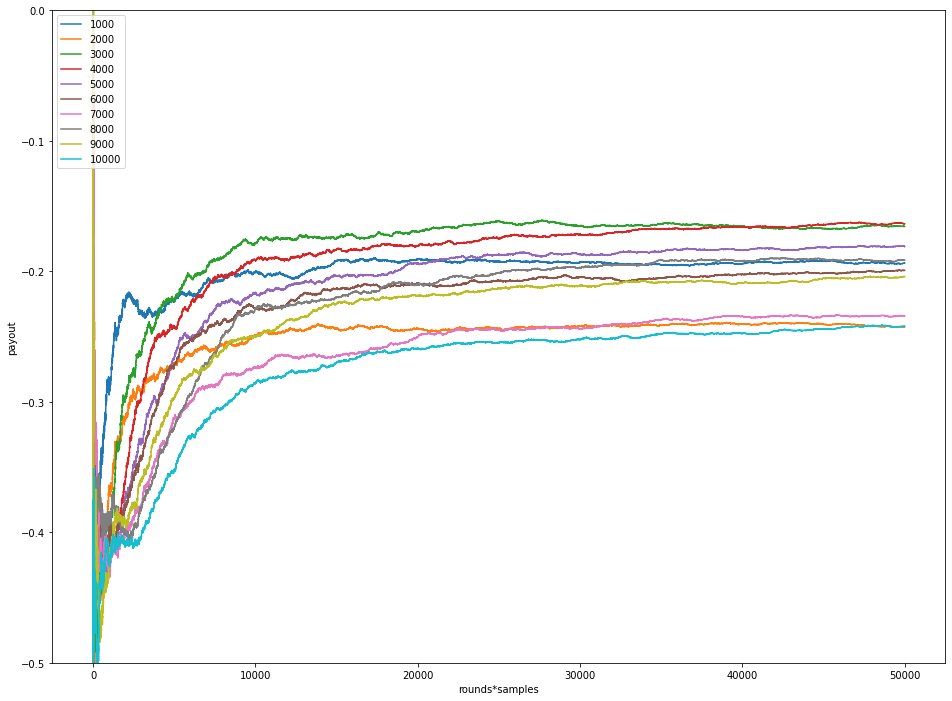

In [12]:
import gym
import matplotlib.pyplot as plt
from gym import wrappers
env = gym.make('Blackjack-v0')

num_rounds = 1000 # payout calculated over num_rounds
num_samples = 50 # num_rounds simulated over num_samples


num_episodes_values = range(1000, 11000, 1000)

fig = plt.figure(num=None, figsize=(16, 12))
plt.clf()
                          
# run simulations over different numbers of episodes to find the one with best payout
for num_episodes_value in num_episodes_values:
    total_payout = 0 # to store total payout over num_rounds
    average_payouts = [] # to store total payout over num_rounds after num_samples simulations
    agent = Agent(env=env, epsilon=1.0, alpha=0.8, gamma=0.9, num_episodes_to_train=num_episodes_value)

    observation = env.reset()
    # reset your hand
    for sample in range(num_samples):
        round = 1
        # take action based on Q-table of the agent and learn based on that until num_episodes_values = 0
        while round <= num_rounds:
            action = agent.choose_action(observation)
            next_observation, payout, is_done, _ = env.step(action)
            agent.learn(observation, action, payout, next_observation)
            total_payout += payout
            observation = next_observation
            if is_done:
                observation = env.reset() # environment deals new cards to player and dealer
                round += 1
                average_payouts.append(total_payout/(sample*num_rounds + round))

    plt.plot(average_payouts)
    print ("Average payout after {} rounds after training for {} episodes is {}".format(num_rounds, num_episodes_value, total_payout/(num_samples)))
    

# plot payout per 1000 episodes for each value of num_episodes_values in the same graph
plt.xlabel('rounds*samples')
plt.ylabel('payout')
plt.legend(["{}".format(i) for i in num_episodes_values], loc='upper left')
plt.ylim(-0.5,0) # To zoom into this region
plt.show()
fig.savefig("Perf_ep.png")
env.close()

**Comment:**
We can see that 4,000 episodes is the optimum as it had the highest average payout/1,000 rounds.

## Carrying out a grid search to find the optimal combination of parameters

Searching for the best combination of `epsilon`, `alpha`, `gamma`.

Average payout after 1000 rounds after training for epsilon value of 0.1, gamma value of 0.1 and alpha value of 0.1 is -112.56
Average payout after 1000 rounds after training for epsilon value of 0.1, gamma value of 0.1 and alpha value of 0.5 is -127.58
Average payout after 1000 rounds after training for epsilon value of 0.1, gamma value of 0.1 and alpha value of 0.9 is -108.28
Average payout after 1000 rounds after training for epsilon value of 0.1, gamma value of 0.5 and alpha value of 0.1 is -190.62
Average payout after 1000 rounds after training for epsilon value of 0.1, gamma value of 0.5 and alpha value of 0.5 is -188.66
Average payout after 1000 rounds after training for epsilon value of 0.1, gamma value of 0.5 and alpha value of 0.9 is -217.56
Average payout after 1000 rounds after training for epsilon value of 0.1, gamma value of 0.9 and alpha value of 0.1 is -303.26
Average payout after 1000 rounds after training for epsilon value of 0.1, gamma value of 0.9 and alpha value of

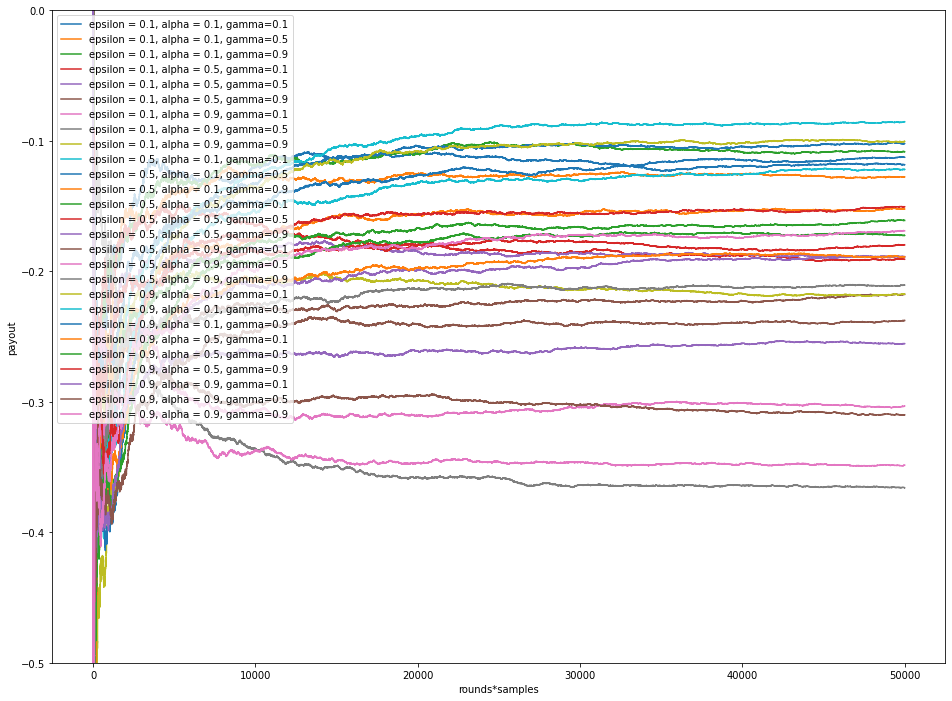

In [13]:
import gym
import matplotlib.pyplot as plt
from gym import wrappers
env = gym.make('Blackjack-v0')

num_rounds = 1000 # payout calculated over num_rounds
num_samples = 50 # num_rounds simulated over num_samples


num_episodes_values = 4000
# searching across high, medium, low values for the parameters
epsilon_values = [0.1, 0.5, 0.9]
alpha_values = [0.1, 0.5, 0.9]
gamma_values = [0.1, 0.5, 0.9]

fig = plt.figure(num=None, figsize=(16, 12))
plt.clf()
                          
# run simulations over different values of epsilon, alpha and gamma to find the one with best payout
for epsilon_value in epsilon_values:
    for alpha_value in alpha_values:
        for gamma_value in gamma_values:
            total_payout = 0 # to store total payout over num_rounds
            average_payouts = [] # to store total payout over num_rounds after num_sample simulations
            agent = Agent(env=env, epsilon=epsilon_value, alpha=alpha_value, gamma=gamma_value, num_episodes_to_train=num_episodes_values)

            observation = env.reset()
            # Reset your handb
            for sample in range(num_samples):
                round = 1
                # take action based on Q-table of the agent and learn based on that until num_episodes_values = 0
                while round <= num_rounds:
                    action = agent.choose_action(observation)
                    next_observation, payout, is_done, _ = env.step(action)
                    agent.learn(observation, action, payout, next_observation)
                    total_payout += payout
                    observation = next_observation
                    if is_done:
                        observation = env.reset() # environment deals new cards to player and dealer
                        round += 1
                        average_payouts.append(total_payout/(sample*num_rounds + round))

            plt.plot(average_payouts)
            print ("Average payout after {} rounds after training for epsilon value of {}, gamma value of {} and alpha value of {} is {}".format(num_rounds, epsilon_value, alpha_value, gamma_value, total_payout/(num_samples)))
    

# plot payout per 1000 episodes for each value of num_episodes_values in the same graph
plt.xlabel('rounds*samples')
plt.ylabel('payout')
plt.legend(["epsilon = {}, alpha = {}, gamma={}".format(i,j,k) for i in epsilon_values for j in alpha_values for k in gamma_values], loc='upper left')
plt.ylim(-0.5,0) # to zoom into this region
plt.show()
fig.savefig("Perf_gridsearch.png")
env.close()

**Comment:**
We can see that the best combination is `episilon`= 0.5, `alpha`=0.1, `gamma`=0.1 as it achieves the highest average payout/1,000 rounds.

## Final Model

The final model is built by implementing the best parameters from the search and the average payout per 1,000 rounds is plotted over 1,000 trials.

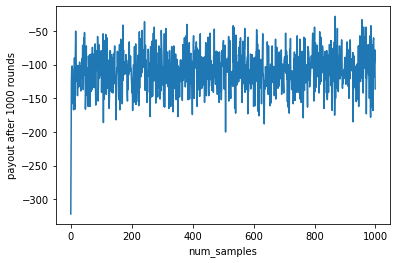

Average payout after 1000 rounds is -108.063


In [14]:
import gym
env = gym.make('Blackjack-v0')
import matplotlib.pyplot as plt

agent = Agent(env=env, epsilon=0.5, alpha=0.1, gamma=0.1, num_episodes_to_train=4000)
# using the optimal parameter combination

num_rounds = 1000 # payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples

average_payouts = []

observation = env.reset()
for sample in range(num_samples):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    # take action based on Q-table of the agent and learn based on that until num_episodes_to_train = 0
    while round <= num_rounds:
        action = agent.choose_action(observation)
        next_observation, payout, is_done, _ = env.step(action)
        agent.learn(observation, action, payout, next_observation)
        total_payout += payout
        observation = next_observation
        if is_done:
            observation = env.reset() # environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

# plot payout per 1000 episodes for each value of num_samples
fig = plt.figure()
plt.plot(average_payouts)           
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()     
fig.savefig("final_model.png")

QL_av_payout = sum(average_payouts)/(num_samples)

print ("Average payout after {} rounds is {}".format(num_rounds, QL_av_payout))

### Performance Comparison

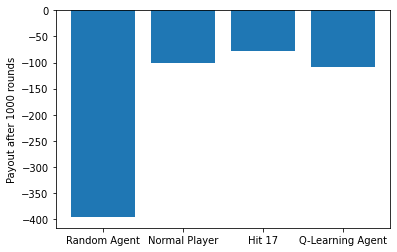

Random Agent Payout: -396.967, Normal Player Payout: -101.036, Hit 17: -78.438, Q-Learning Agent Payout: -108.063


In [15]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.bar(['Random Agent', 'Normal Player', 'Hit 17', 'Q-Learning Agent'],[rand_av_payouts, norm_av_payout, hit17_av_payout, QL_av_payout])
plt.ylabel("Payout after 1000 rounds")
plt.show()
fig.savefig("Payout_comp_ALL.png")
print("Random Agent Payout: {}, Normal Player Payout: {}, Hit 17: {}, Q-Learning Agent Payout: {}".format(rand_av_payouts,norm_av_payout, hit17_av_payout, QL_av_payout))

**Comment:**
We can see that the Q-learning agent does not beat the Hit 17 strategy or the Normal Player but it does beat the Random Agent.

### Analysing the strategy learned

In [16]:
import gym
env = gym.make('Blackjack-v0')

agent = Agent(env=env, epsilon=0.5, alpha=0.1, gamma=0.1, num_episodes_to_train=4000)

num_rounds = 1000 # payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples

payouts = []

observation = env.reset()
round = 1
total_payout = 0 # to store total payout over num_rounds
# take action based on Q-table of the agent and learn based on that until num_episodes_to_train = 0
while round <= num_rounds * num_samples:
    action = agent.choose_action(observation)
    next_observation, payout, is_done, _ = env.step(action)
    agent.learn(observation, action, payout, next_observation)
    payouts.append(payout)
    observation = next_observation
    if is_done:
        observation = env.reset() # environment deals new cards to player and dealer
        round += 1

num_observations = 0        
list_players_hand = range(1, 22)
list_dealers_upcard = range(1, 11)

def readable_action(observation, agent):
    """ 
    Pass observation to agent and get human readable action
    H is hit, S is stick and '-' means the state is unseen and a random action is taken
    """
    if observation not in agent.Q:
        action = "-"
    else:
        action = "H" if agent.choose_action(observation) else "S"    
    return action

# print headers to give more information about output
print ("{:^10} | {:^50} | {:^50}".format("Player's","Dealer's upcard when ace is not usable", "Dealer's upcard when ace is usable"))
print ("{0:^10} | {1} | {1}".format("Hand", [str(upcard) if not upcard==10 else 'A' 
                                                        for upcard in list_dealers_upcard]))
print (''.join(['-' for _ in range(116)]))
for players_hand in list_players_hand:
    actions_usable = []
    actions_not_usable = []
    for dealers_upcard in list_dealers_upcard:
        observation = (players_hand, dealers_upcard, False)
        actions_not_usable.append(readable_action(observation, agent))
        observation = (players_hand, dealers_upcard, True)
        actions_usable.append(readable_action(observation, agent))
    
    print ("{:>10} | {} | {}".format(players_hand, actions_not_usable, actions_usable))
    
#print ("Average payout after {} rounds is {}".format(num_rounds, sum(payouts)/num_samples))

 Player's  |       Dealer's upcard when ace is not usable       |         Dealer's upcard when ace is usable        
   Hand    | ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A'] | ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A']
--------------------------------------------------------------------------------------------------------------------
         1 | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'] | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         2 | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'] | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         3 | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'] | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         4 | ['S', 'S', 'S', 'H', 'S', 'S', 'S', 'H', 'H', 'H'] | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         5 | ['H', 'H', 'H', 'H', 'H', 'H', 'H', 'S', 'H', 'H'] | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         6 | ['S', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'] 